In [1]:
# oppress all warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# avoidn unnecessary zeros
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import io
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
from geopy.geocoders import Nominatim
from time import sleep
from datetime import datetime

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


# Calculate AMI Index for Weekday and weekend separately

In [4]:
# read hourly volume
hr_vol2=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/eco_hourly_clean_volume.csv')
# read permanent counters data afte QA and QC check
Permanent_counter=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/permanent_counter_2019_2016_AADBT_data.csv')

In [5]:
# Select the useable permanent counters only
ami=pd.merge(hr_vol2,Permanent_counter,left_on=['ID','year'],right_on=['ID','year'],how='inner')
ami.head()

Unnamed: 0_x  index   ID  year  month  day  weekno  dayofweek  \
0             7      7  671  2016      1    1      53          4   
1            31     31  671  2016      1    2      53          5   
2            55     55  671  2016      1    3      53          6   
3            79     79  671  2016      1    4       1          0   
4           103    103  671  2016      1    5       1          1   

   weekday_Status starttime  ...  day_night  location_x  Flag Unnamed: 0_y  \
0               0  07:00:00  ...      night       urban     0          385   
1               1  07:00:00  ...      night       urban     0          385   
2               1  07:00:00  ...      night       urban     0          385   
3               0  07:00:00  ...      night       urban     0          385   
4               0  07:00:00  ...      night       urban     0          385   

  location_y latitude_y longitude_y  AADBT  no_of_months_data_collected  \
0      urban      37.79     -122.46  53.55                           12   
1      urban      37.79     -122.46  53.55                           12   
2      urban      37.79     -122.46  53.55                           12   
3      urban      37.79     -122.46  53.55                           12   
4      urban      37.79     -122.46  53.55                           12   

            type  
0  eco_permanent  
1  eco_permanent  
2  eco_permanent  
3  eco_permanent  
4  eco_permanent  

[5 rows x 25 columns]

## Weekday and Weekend AMI

In [6]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
ami['Day of Week'] = ami['Day of Week'].astype(cat_type)

In [7]:
# Calculate AM Count by eco id
df181am1=ami[(ami['starttime']=='07:00:00')]
df181am2=ami[(ami['starttime']=='08:00:00')]
df181am=pd.concat([df181am1,df181am2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181amg=pd.DataFrame({'AM_count' : df181am.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Calculate pM count by Eco ID
df181pm1=ami[(ami['starttime']=='11:00:00')]
df181pm2=ami[(ami['starttime']=='12:00:00')]
df181pm=pd.concat([df181pm1,df181pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'PM_count' : df181pm.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_am_pm=pd.merge(df181amg,df181pmg,left_on=['ID','year','Day of Week','Week Day Status'],right_on=['ID','year','Day of Week','Week Day Status'],how='inner')
# Calculate the AMI
df181_am_pm['AMI']=df181_am_pm['AM_count']/df181_am_pm['PM_count']
df181_am_pm.head()

ID  year Day of Week Week Day Status  AM_count  PM_count  AMI
0  671  2016      Monday        Week Day    171.00    383.00 0.45
1  671  2016      Monday         Weekend      0.00      0.00  NaN
2  671  2016     Tuesday        Week Day    282.00    303.00 0.93
3  671  2016     Tuesday         Weekend      0.00      0.00  NaN
4  671  2016   Wednesday        Week Day    266.00    300.00 0.89

In [8]:
# exclude some of the anomally
df181_am_pm=df181_am_pm.loc[df181_am_pm['AMI']<10]
df181_am_pm.head()

ID  year Day of Week Week Day Status  AM_count  PM_count  AMI
0  671  2016      Monday        Week Day    171.00    383.00 0.45
2  671  2016     Tuesday        Week Day    282.00    303.00 0.93
4  671  2016   Wednesday        Week Day    266.00    300.00 0.89
6  671  2016    Thursday        Week Day    260.00    335.00 0.78
8  671  2016      Friday        Week Day    208.00    437.00 0.48

In [9]:
# Calculate daily max AMI
Daily_AMI_max=pd.DataFrame({'Daily_Max_AMI' : df181_am_pm.groupby(['ID','year'])['AMI'].max()}).reset_index()
Daily_AMI_max.head()

ID  year  Daily_Max_AMI
0   671  2016           0.93
1   671  2017           1.02
2   671  2018           1.43
3   671  2019           1.21
4  1127  2016           2.24

In [10]:
# Calculate max AMI
AMI_max=pd.DataFrame({'Max_AMI' : df181_am_pm.groupby(['ID','year','Week Day Status'])['AMI'].max()}).reset_index()
AMI_max.head()

ID  year Week Day Status  Max_AMI
0  671  2016        Week Day     0.93
1  671  2016         Weekend     0.36
2  671  2017        Week Day     1.02
3  671  2017         Weekend     0.44
4  671  2018        Week Day     1.43

In [11]:
# Calculate max weekday AMI
Weekday_AMI_max=AMI_max.loc[AMI_max['Week Day Status']=='Week Day']
Weekday_AMI_max=Weekday_AMI_max.rename(columns={'Max_AMI':'Max_weekday_AMI'})
Weekday_AMI_max=Weekday_AMI_max[['ID','year','Max_weekday_AMI']]
Weekday_AMI_max.head()

ID  year  Max_weekday_AMI
0   671  2016             0.93
2   671  2017             1.02
4   671  2018             1.43
6   671  2019             1.21
8  1127  2016             2.24

In [12]:
# calculate max weekend AMI
Weekend_AMI_max=AMI_max.loc[AMI_max['Week Day Status']=='Weekend']
Weekend_AMI_max=Weekend_AMI_max.rename(columns={'Max_AMI':'Max_weekend_AMI'})
Weekend_AMI_max=Weekend_AMI_max[['ID','year','Max_weekend_AMI']]
Weekend_AMI_max.head()

ID  year  Max_weekend_AMI
1   671  2016             0.36
3   671  2017             0.44
5   671  2018             0.30
7   671  2019             0.35
9  1127  2016             0.74

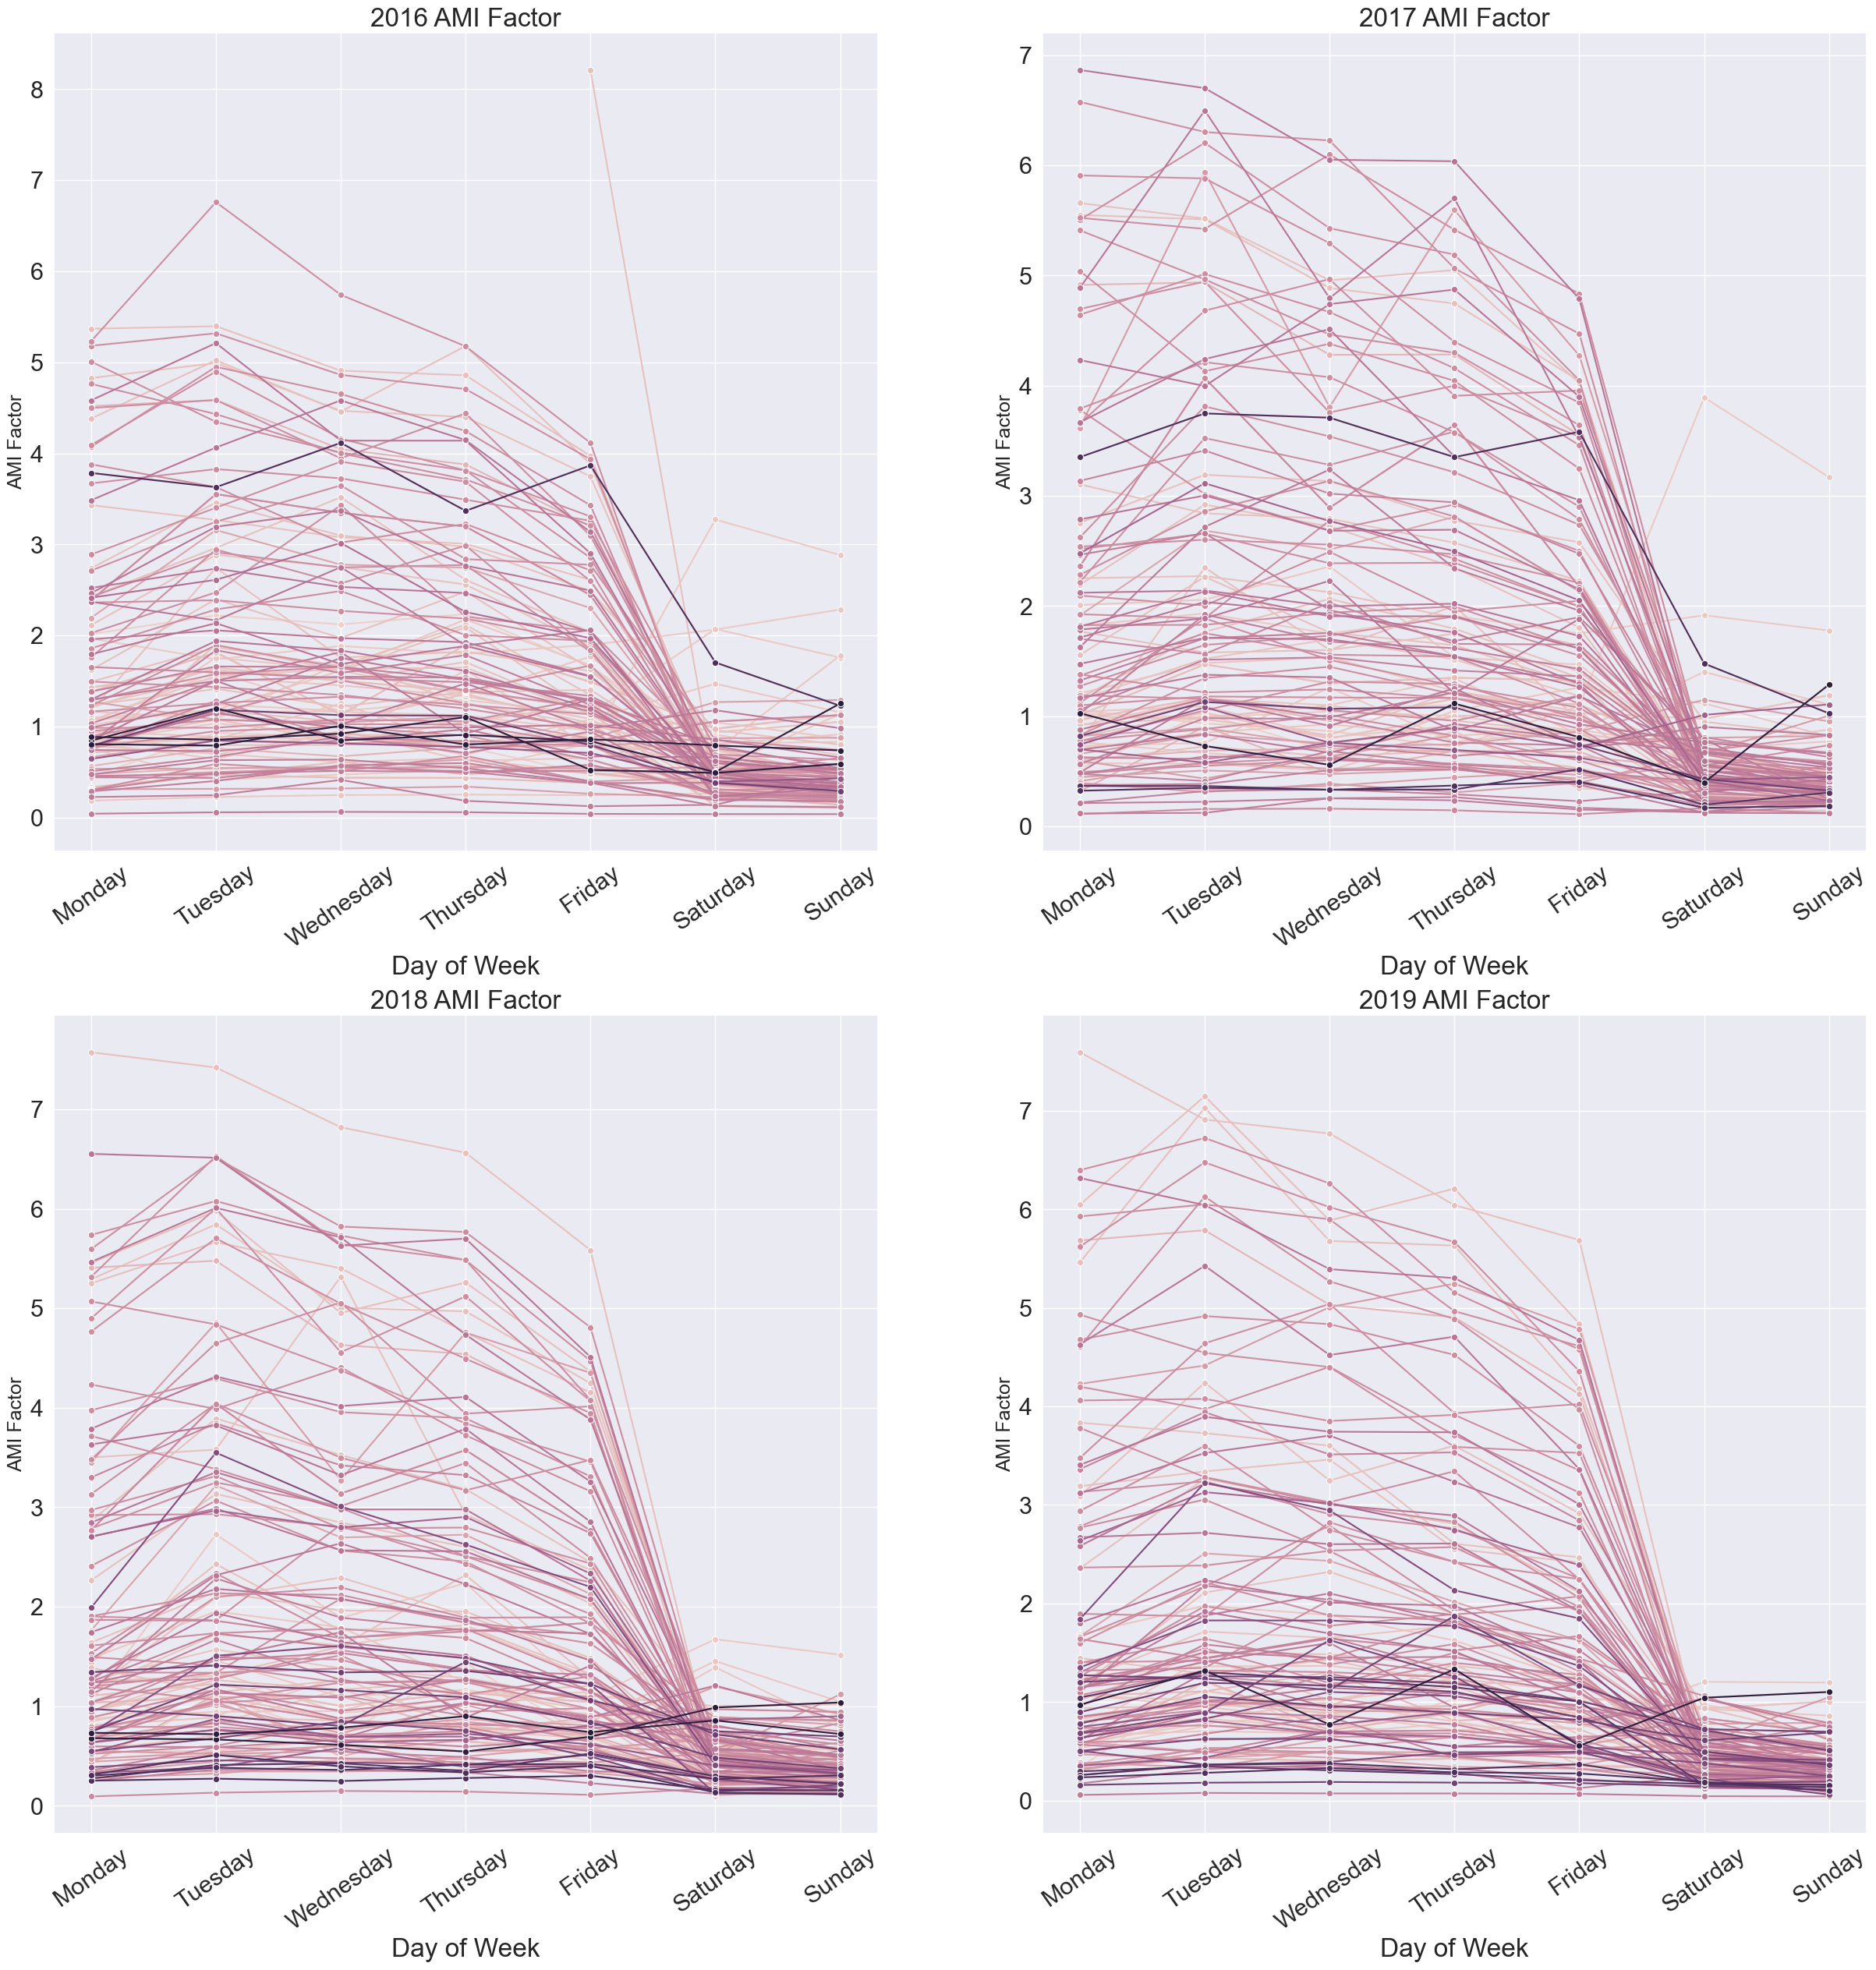

In [13]:
sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=2.0)
import seaborn as sns
ami16=df181_am_pm.loc[df181_am_pm['year']==2016]
ami17=df181_am_pm.loc[df181_am_pm['year']==2017]
ami18=df181_am_pm.loc[df181_am_pm['year']==2018]
ami19=df181_am_pm.loc[df181_am_pm['year']==2019]


fig, ax = plt.subplots(2,2)

ax1 = sns.lineplot(x=ami16['Day of Week'],y=ami16['AMI'],hue=ami16['ID'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.lineplot(x=ami17['Day of Week'],y=ami17['AMI'],hue=ami17['ID'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.lineplot(x=ami18['Day of Week'],y=ami18['AMI'],hue=ami18['ID'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.lineplot(x=ami19['Day of Week'],y=ami19['AMI'],hue=ami19['ID'],
                   markers=True, marker="o", dashes=False,sort=True,ax=ax[1,1]) 
plt.xticks(rotation = 'vertical')
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax1.title.set_text('2016 AMI Factor')
ax2.title.set_text('2017 AMI Factor')
ax3.title.set_text('2018 AMI Factor')
ax4.title.set_text('2019 AMI Factor')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=35)
ax1.set_ylabel('AMI Factor',fontsize=18)
ax1.set_xlabel('Day of Week')
ax2.set_ylabel('AMI Factor',fontsize=18 )
ax2.set_xlabel('Day of Week')
ax3.set_ylabel('AMI Factor',fontsize=18 )
ax3.set_xlabel('Day of Week')
ax4.set_ylabel('AMI Factor',fontsize=18 )
ax4.set_xlabel('Day of Week')
plt.show()

In [14]:
# Calculate Average weekday, weekend AMI and its ratio
AMI_Ave=pd.DataFrame({'Aergage_AMI' : df181_am_pm.groupby(['ID','year','Week Day Status'])['AMI'].mean()}).reset_index()
AMI_Ave_weekday=AMI_Ave.loc[AMI_Ave['Week Day Status']=='Week Day']
AMI_Ave_weekday=AMI_Ave_weekday.rename(columns={'Aergage_AMI':'Weekday_Aergage_AMI'})
AMI_Ave_weekend=AMI_Ave.loc[AMI_Ave['Week Day Status']=='Weekend']
AMI_Ave_weekend=AMI_Ave_weekend.rename(columns={'Aergage_AMI':'Weekend_Aergage_AMI'})
AMI_ratio=pd.merge(AMI_Ave_weekday,AMI_Ave_weekend,left_on=['ID','year'],right_on=['ID','year'],how='inner')
AMI_ratio['Average AMI_wday_wend']=AMI_ratio['Weekday_Aergage_AMI']/AMI_ratio['Weekend_Aergage_AMI']
AMI_ratio.head()

ID  year Week Day Status_x  Weekday_Aergage_AMI Week Day Status_y  \
0   671  2016          Week Day                 0.70           Weekend   
1   671  2017          Week Day                 0.74           Weekend   
2   671  2018          Week Day                 0.86           Weekend   
3   671  2019          Week Day                 0.82           Weekend   
4  1127  2016          Week Day                 2.05           Weekend   

   Weekend_Aergage_AMI  Average AMI_wday_wend  
0                 0.32                   2.17  
1                 0.38                   1.97  
2                 0.29                   2.97  
3                 0.34                   2.41  
4                 0.58                   3.51

In [15]:
AMI_ratio1=AMI_ratio[['ID','year','Weekday_Aergage_AMI','Weekend_Aergage_AMI','Average AMI_wday_wend']]
AMI_ratio1.shape

(497, 5)

In [16]:
# combined AMI indices
all_AMI_indices=pd.merge(AMI_ratio1,Weekend_AMI_max,left_on=['ID','year'],right_on=['ID','year'],how='outer')
all_AMI_indices1=pd.merge(all_AMI_indices,Weekday_AMI_max,left_on=['ID','year'],right_on=['ID','year'],how='outer')
all_AMI_indices2=pd.merge(all_AMI_indices1,Daily_AMI_max,left_on=['ID','year'],right_on=['ID','year'],how='outer')
all_AMI_indices2.head()

ID  year  Weekday_Aergage_AMI  Weekend_Aergage_AMI  \
0   671  2016                 0.70                 0.32   
1   671  2017                 0.74                 0.38   
2   671  2018                 0.86                 0.29   
3   671  2019                 0.82                 0.34   
4  1127  2016                 2.05                 0.58   

   Average AMI_wday_wend  Max_weekend_AMI  Max_weekday_AMI  Daily_Max_AMI  
0                   2.17             0.36             0.93           0.93  
1                   1.97             0.44             1.02           1.02  
2                   2.97             0.30             1.43           1.43  
3                   2.41             0.35             1.21           1.21  
4                   3.51             0.74             2.24           2.24

# PMI Index

In [17]:
# Calculate AM Count by eco id
df181pm1=ami[(ami['starttime']=='17:00:00')]
df181pm2=ami[(ami['starttime']=='18:00:00')]
df181pm=pd.concat([df181pm1,df181pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'late_PM_count' : df181pm.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Calculate pM count by Eco ID
df181pm2g1=ami[(ami['starttime']=='11:00:00')]
df181pm2g2=ami[(ami['starttime']=='12:00:00')]
df181pm2g=pd.concat([df181pm2g1,df181pm2g2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pm2g=pd.DataFrame({'early_PM_count' : df181pm2g.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_pm_pm=pd.merge(df181pmg,df181pm2g,left_on=['ID','year','Day of Week','Week Day Status'],right_on=['ID','year','Day of Week','Week Day Status'],how='inner')
# Calculate the AMI
df181_pm_pm['PMI']=df181_pm_pm['late_PM_count']/df181_pm_pm['early_PM_count']
df181_pm_pm.head()

ID  year Day of Week Week Day Status  late_PM_count  early_PM_count  PMI
0  671  2016      Monday        Week Day         326.00          383.00 0.85
1  671  2016      Monday         Weekend           0.00            0.00  NaN
2  671  2016     Tuesday        Week Day         352.00          303.00 1.16
3  671  2016     Tuesday         Weekend           0.00            0.00  NaN
4  671  2016   Wednesday        Week Day         368.00          300.00 1.23

In [18]:
# calculate daily Max PMI
Daily_PMI_max=pd.DataFrame({'Daily_Max_PMI' : df181_pm_pm.groupby(['ID','year'])['PMI'].max()}).reset_index()
Daily_PMI_max.head()

ID  year  Daily_Max_PMI
0   671  2016           1.23
1   671  2017           1.21
2   671  2018           1.30
3   671  2019           1.13
4  1127  2016           0.91

In [19]:
# Calculate Max Weekend PMI
PMI_max=pd.DataFrame({'Max_PMI' : df181_pm_pm.groupby(['ID','year','Week Day Status'])['PMI'].max()}).reset_index()
Weekday_PMI_max=PMI_max.loc[PMI_max['Week Day Status']=='Week Day']
Weekday_PMI_max=Weekday_PMI_max.rename(columns={'Max_PMI':'Max_weekday_PMI'})
Weekday_PMI_max=Weekday_PMI_max[['ID','year','Max_weekday_PMI']]

Weekend_PMI_max=PMI_max.loc[PMI_max['Week Day Status']=='Weekend']
Weekend_PMI_max=Weekend_PMI_max.rename(columns={'Max_PMI':'Max_weekend_PMI'})
Weekend_PMI_max=Weekend_PMI_max[['ID','year','Max_weekend_PMI']]
Weekend_PMI_max.head()

ID  year  Max_weekend_PMI
1   671  2016             0.49
3   671  2017             0.49
5   671  2018             0.39
7   671  2019             0.42
9  1127  2016             0.91

In [20]:
# calculate weekday, weekend average PMI and its ratio
PMI_Ave=pd.DataFrame({'Aergage_PMI' : df181_pm_pm.groupby(['ID','year','Week Day Status'])['PMI'].mean()}).reset_index()
PMI_Ave_weekday=PMI_Ave.loc[PMI_Ave['Week Day Status']=='Week Day']
PMI_Ave_weekday=PMI_Ave_weekday.rename(columns={'Aergage_PMI':'Weekday_Aergage_PMI'})
PMI_Ave_weekend=PMI_Ave.loc[PMI_Ave['Week Day Status']=='Weekend']
PMI_Ave_weekend=PMI_Ave_weekend.rename(columns={'Aergage_PMI':'Weekend_Aergage_PMI'})
PMI_ratio=pd.merge(PMI_Ave_weekday,PMI_Ave_weekend,left_on=['ID','year'],right_on=['ID','year'],how='inner')
PMI_ratio['Average PMI_wday_wend']=PMI_ratio['Weekday_Aergage_PMI']/PMI_ratio['Weekend_Aergage_PMI']
PMI_ratio=PMI_ratio[['ID','year','Weekday_Aergage_PMI','Weekend_Aergage_PMI','Average PMI_wday_wend']]
PMI_ratio.head()

ID  year  Weekday_Aergage_PMI  Weekend_Aergage_PMI  Average PMI_wday_wend
0   671  2016                 1.01                 0.46                   2.21
1   671  2017                 0.97                 0.47                   2.07
2   671  2018                 0.99                 0.36                   2.73
3   671  2019                 0.98                 0.38                   2.56
4  1127  2016                 0.74                 0.83                   0.89

In [21]:
# combine all PMI Indices
PMI1=pd.merge(Daily_PMI_max,PMI_ratio,left_on=["ID",'year'],right_on=["ID",'year'], how='outer')
PMI2=pd.merge(Weekday_PMI_max,Weekend_PMI_max,left_on=["ID",'year'],right_on=["ID",'year'], how='outer')
PMI=pd.merge(PMI1,PMI2,left_on=["ID",'year'],right_on=["ID",'year'], how='outer')
PMI.head()

ID  year  Daily_Max_PMI  Weekday_Aergage_PMI  Weekend_Aergage_PMI  \
0   671  2016           1.23                 1.01                 0.46   
1   671  2017           1.21                 0.97                 0.47   
2   671  2018           1.30                 0.99                 0.36   
3   671  2019           1.13                 0.98                 0.38   
4  1127  2016           0.91                 0.74                 0.83   

   Average PMI_wday_wend  Max_weekday_PMI  Max_weekend_PMI  
0                   2.21             1.23             0.49  
1                   2.07             1.21             0.49  
2                   2.73             1.30             0.39  
3                   2.56             1.13             0.42  
4                   0.89             0.78             0.91

In [22]:
# combine AMI and PMI indices together
AMI_PMI=pd.merge(all_AMI_indices2,PMI,left_on=["ID",'year'],right_on=["ID",'year'], how='inner')
AMI_PMI.head()

ID  year  Weekday_Aergage_AMI  Weekend_Aergage_AMI  \
0   671  2016                 0.70                 0.32   
1   671  2017                 0.74                 0.38   
2   671  2018                 0.86                 0.29   
3   671  2019                 0.82                 0.34   
4  1127  2016                 2.05                 0.58   

   Average AMI_wday_wend  Max_weekend_AMI  Max_weekday_AMI  Daily_Max_AMI  \
0                   2.17             0.36             0.93           0.93   
1                   1.97             0.44             1.02           1.02   
2                   2.97             0.30             1.43           1.43   
3                   2.41             0.35             1.21           1.21   
4                   3.51             0.74             2.24           2.24   

   Daily_Max_PMI  Weekday_Aergage_PMI  Weekend_Aergage_PMI  \
0           1.23                 1.01                 0.46   
1           1.21                 0.97                 0.47   
2           1.30                 0.99                 0.36   
3           1.13                 0.98                 0.38   
4           0.91                 0.74                 0.83   

   Average PMI_wday_wend  Max_weekday_PMI  Max_weekend_PMI  
0                   2.21             1.23             0.49  
1                   2.07             1.21             0.49  
2                   2.73             1.30             0.39  
3                   2.56             1.13             0.42  
4                   0.89             0.78             0.91

In [23]:
# define Function to calculate Max indices value
def max(Daily_Max_AMI,Daily_Max_PMI):
    if Daily_Max_AMI>Daily_Max_PMI:
        return 'AM'
    else:
        return 'PM'
def max_value(Daily_Max_AMI,Daily_Max_PMI):
    if Daily_Max_AMI>Daily_Max_PMI:
        return Daily_Max_AMI
    else:
        return Daily_Max_PMI
    

def max_weekend(Max_weekend_AMI,Max_weekend_PMI):
    if Max_weekend_AMI>Max_weekend_PMI:
        return 'AMI'
    else:
        return 'PMI'
    
def max_weekend_value(Max_weekend_AMI,Max_weekend_PMI):
    if Max_weekend_AMI>Max_weekend_PMI:
        return Max_weekend_AMI
    else:
        return Max_weekend_PMI
    
def max_weekday(Max_weekday_AMI,Max_weekday_PMI):
    if Max_weekday_AMI>Max_weekday_PMI:
        return 'AMI'
    else:
        return 'PMI'
    
def max_weekday_value(Max_weekday_AMI,Max_weekday_PMI):
    if Max_weekday_AMI>Max_weekday_PMI:
        return Max_weekday_AMI
    else:
        return Max_weekday_PMI

In [24]:
AMI_PMI['max_daily_am/pm']=AMI_PMI.apply(lambda row:max(row['Daily_Max_AMI'],row['Daily_Max_PMI']),axis=1)
AMI_PMI['max_daily_am/pm_value']=AMI_PMI.apply(lambda row:max_value(row['Daily_Max_AMI'],row['Daily_Max_PMI']),axis=1)
AMI_PMI['max_weekend_am/pm']=AMI_PMI.apply(lambda row:max_weekend(row['Max_weekend_AMI'],row['Max_weekend_PMI']),axis=1)
AMI_PMI['max_weekend_am/pm_Value']=AMI_PMI.apply(lambda row:max_weekend_value(row['Max_weekend_AMI'],row['Max_weekend_PMI']),axis=1)
AMI_PMI['max_weekday_am/pm']=AMI_PMI.apply(lambda row:max_weekday(row['Max_weekday_AMI'],row['Max_weekday_PMI']),axis=1)
AMI_PMI['max_weekday_am/pm_value']=AMI_PMI.apply(lambda row:max_weekday_value(row['Max_weekday_AMI'],row['Max_weekday_PMI']),axis=1)
AMI_PMI.head()

ID  year  Weekday_Aergage_AMI  Weekend_Aergage_AMI  \
0   671  2016                 0.70                 0.32   
1   671  2017                 0.74                 0.38   
2   671  2018                 0.86                 0.29   
3   671  2019                 0.82                 0.34   
4  1127  2016                 2.05                 0.58   

   Average AMI_wday_wend  Max_weekend_AMI  Max_weekday_AMI  Daily_Max_AMI  \
0                   2.17             0.36             0.93           0.93   
1                   1.97             0.44             1.02           1.02   
2                   2.97             0.30             1.43           1.43   
3                   2.41             0.35             1.21           1.21   
4                   3.51             0.74             2.24           2.24   

   Daily_Max_PMI  Weekday_Aergage_PMI  Weekend_Aergage_PMI  \
0           1.23                 1.01                 0.46   
1           1.21                 0.97                 0.47   
2           1.30                 0.99                 0.36   
3           1.13                 0.98                 0.38   
4           0.91                 0.74                 0.83   

   Average PMI_wday_wend  Max_weekday_PMI  Max_weekend_PMI max_daily_am/pm  \
0                   2.21             1.23             0.49              PM   
1                   2.07             1.21             0.49              PM   
2                   2.73             1.30             0.39              AM   
3                   2.56             1.13             0.42              AM   
4                   0.89             0.78             0.91              AM   

   max_daily_am/pm_value max_weekend_am/pm  max_weekend_am/pm_Value  \
0                   1.23               PMI                     0.49   
1                   1.21               PMI                     0.49   
2                   1.43               PMI                     0.39   
3                   1.21               PMI                     0.42   
4                   2.24               PMI                     0.91   

  max_weekday_am/pm  max_weekday_am/pm_value  
0               PMI                     1.23  
1               PMI                     1.21  
2               AMI                     1.43  
3               AMI                     1.21  
4               AMI                     2.24

In [25]:
# check the shape of the data
AMI_PMI.shape

(497, 20)

## Weekday /Weekend Index

In [26]:
# Calculate weekend Count by eco id
df181_weekend=ami.loc[ami['weekday_Status']==1]
#df181_weekendg=pd.DataFrame({'Weekend_count' : df181_weekend.groupby(['ID','year'])['counts'].sum()}).reset_index()

# Calculate weekday count by Eco ID
df181_weeekday=ami.loc[ami['weekday_Status']==0]
#df181_weekdayg=pd.DataFrame({'Weekday_count' : df181_weeekday.groupby(['ID','year'])['counts'].sum()}).reset_index()

# Join weekend and weekday count by eco id
#df181_weekend_weekday=pd.merge(df181_weekendg,df181_weekdayg,left_on=["ID",'year'],right_on=["ID",'year'],how='inner')
# Calculate the WWI
#df181_weekend_weekday['WWI']=df181_weekend_weekday['Weekend_count']/df181_weekend_weekday['Weekday_count']
#df181_weekend_weekday.head()

In [27]:
df181_weekendg1=pd.DataFrame({'Weekend_count1' : df181_weekend.groupby(['ID','year','weekno'])['counts'].sum()}).reset_index()
df181_weekdayg1=pd.DataFrame({'Weekday_count1' : df181_weeekday.groupby(['ID','year','weekno'])['counts'].sum()}).reset_index()
df181_weekend_weekday1=pd.merge(df181_weekendg1,df181_weekdayg1,left_on=["ID",'year','weekno'],right_on=["ID",'year','weekno'],how='inner')
df181_weekend_weekday1['weekly_WWI']=df181_weekend_weekday1['Weekend_count1']/df181_weekend_weekday1['Weekday_count1']
df181_weekend_weekday1.head()

ID  year  weekno  Weekend_count1  Weekday_count1  weekly_WWI
0  671  2016       1          126.00          105.00        1.20
1  671  2016       2           81.00          118.00        0.69
2  671  2016       3          155.00          143.00        1.08
3  671  2016       4          203.00          131.00        1.55
4  671  2016       5          208.00          153.00        1.36

In [28]:
WWI_max=pd.DataFrame({'Max_WWI' : df181_weekend_weekday1.groupby(['ID','year'])['weekly_WWI'].max()}).reset_index()
WWI=pd.DataFrame({'Average_WWI' : df181_weekend_weekday1.groupby(['ID','year'])['weekly_WWI'].mean()}).reset_index()
all_wwi=pd.merge(WWI_max,WWI,left_on=["ID",'year'],right_on=["ID",'year'],how='inner')
all_wwi.head()

ID  year  Max_WWI  Average_WWI
0   671  2016     2.23         0.77
1   671  2017     2.89         0.78
2   671  2018     1.35         0.71
3   671  2019     1.44         0.66
4  1127  2016     2.22         0.26

In [29]:
# combine AMI_PMI and WWI
AMI_PMI_WWI=pd.merge(all_wwi,AMI_PMI,left_on=["ID",'year'],right_on=["ID",'year'],how='inner')
AMI_PMI_WWI.head()

ID  year  Max_WWI  Average_WWI  Weekday_Aergage_AMI  Weekend_Aergage_AMI  \
0   671  2016     2.23         0.77                 0.70                 0.32   
1   671  2017     2.89         0.78                 0.74                 0.38   
2   671  2018     1.35         0.71                 0.86                 0.29   
3   671  2019     1.44         0.66                 0.82                 0.34   
4  1127  2016     2.22         0.26                 2.05                 0.58   

   Average AMI_wday_wend  Max_weekend_AMI  Max_weekday_AMI  Daily_Max_AMI  \
0                   2.17             0.36             0.93           0.93   
1                   1.97             0.44             1.02           1.02   
2                   2.97             0.30             1.43           1.43   
3                   2.41             0.35             1.21           1.21   
4                   3.51             0.74             2.24           2.24   

   ...  Weekend_Aergage_PMI  Average PMI_wday_wend  Max_weekday_PMI  \
0  ...                 0.46                   2.21             1.23   
1  ...                 0.47                   2.07             1.21   
2  ...                 0.36                   2.73             1.30   
3  ...                 0.38                   2.56             1.13   
4  ...                 0.83                   0.89             0.78   

   Max_weekend_PMI  max_daily_am/pm  max_daily_am/pm_value max_weekend_am/pm  \
0             0.49               PM                   1.23               PMI   
1             0.49               PM                   1.21               PMI   
2             0.39               AM                   1.43               PMI   
3             0.42               AM                   1.21               PMI   
4             0.91               AM                   2.24               PMI   

   max_weekend_am/pm_Value max_weekday_am/pm  max_weekday_am/pm_value  
0                     0.49               PMI                     1.23  
1                     0.49               PMI                     1.21  
2                     0.39               AMI                     1.43  
3                     0.42               AMI                     1.21  
4                     0.91               AMI                     2.24  

[5 rows x 22 columns]

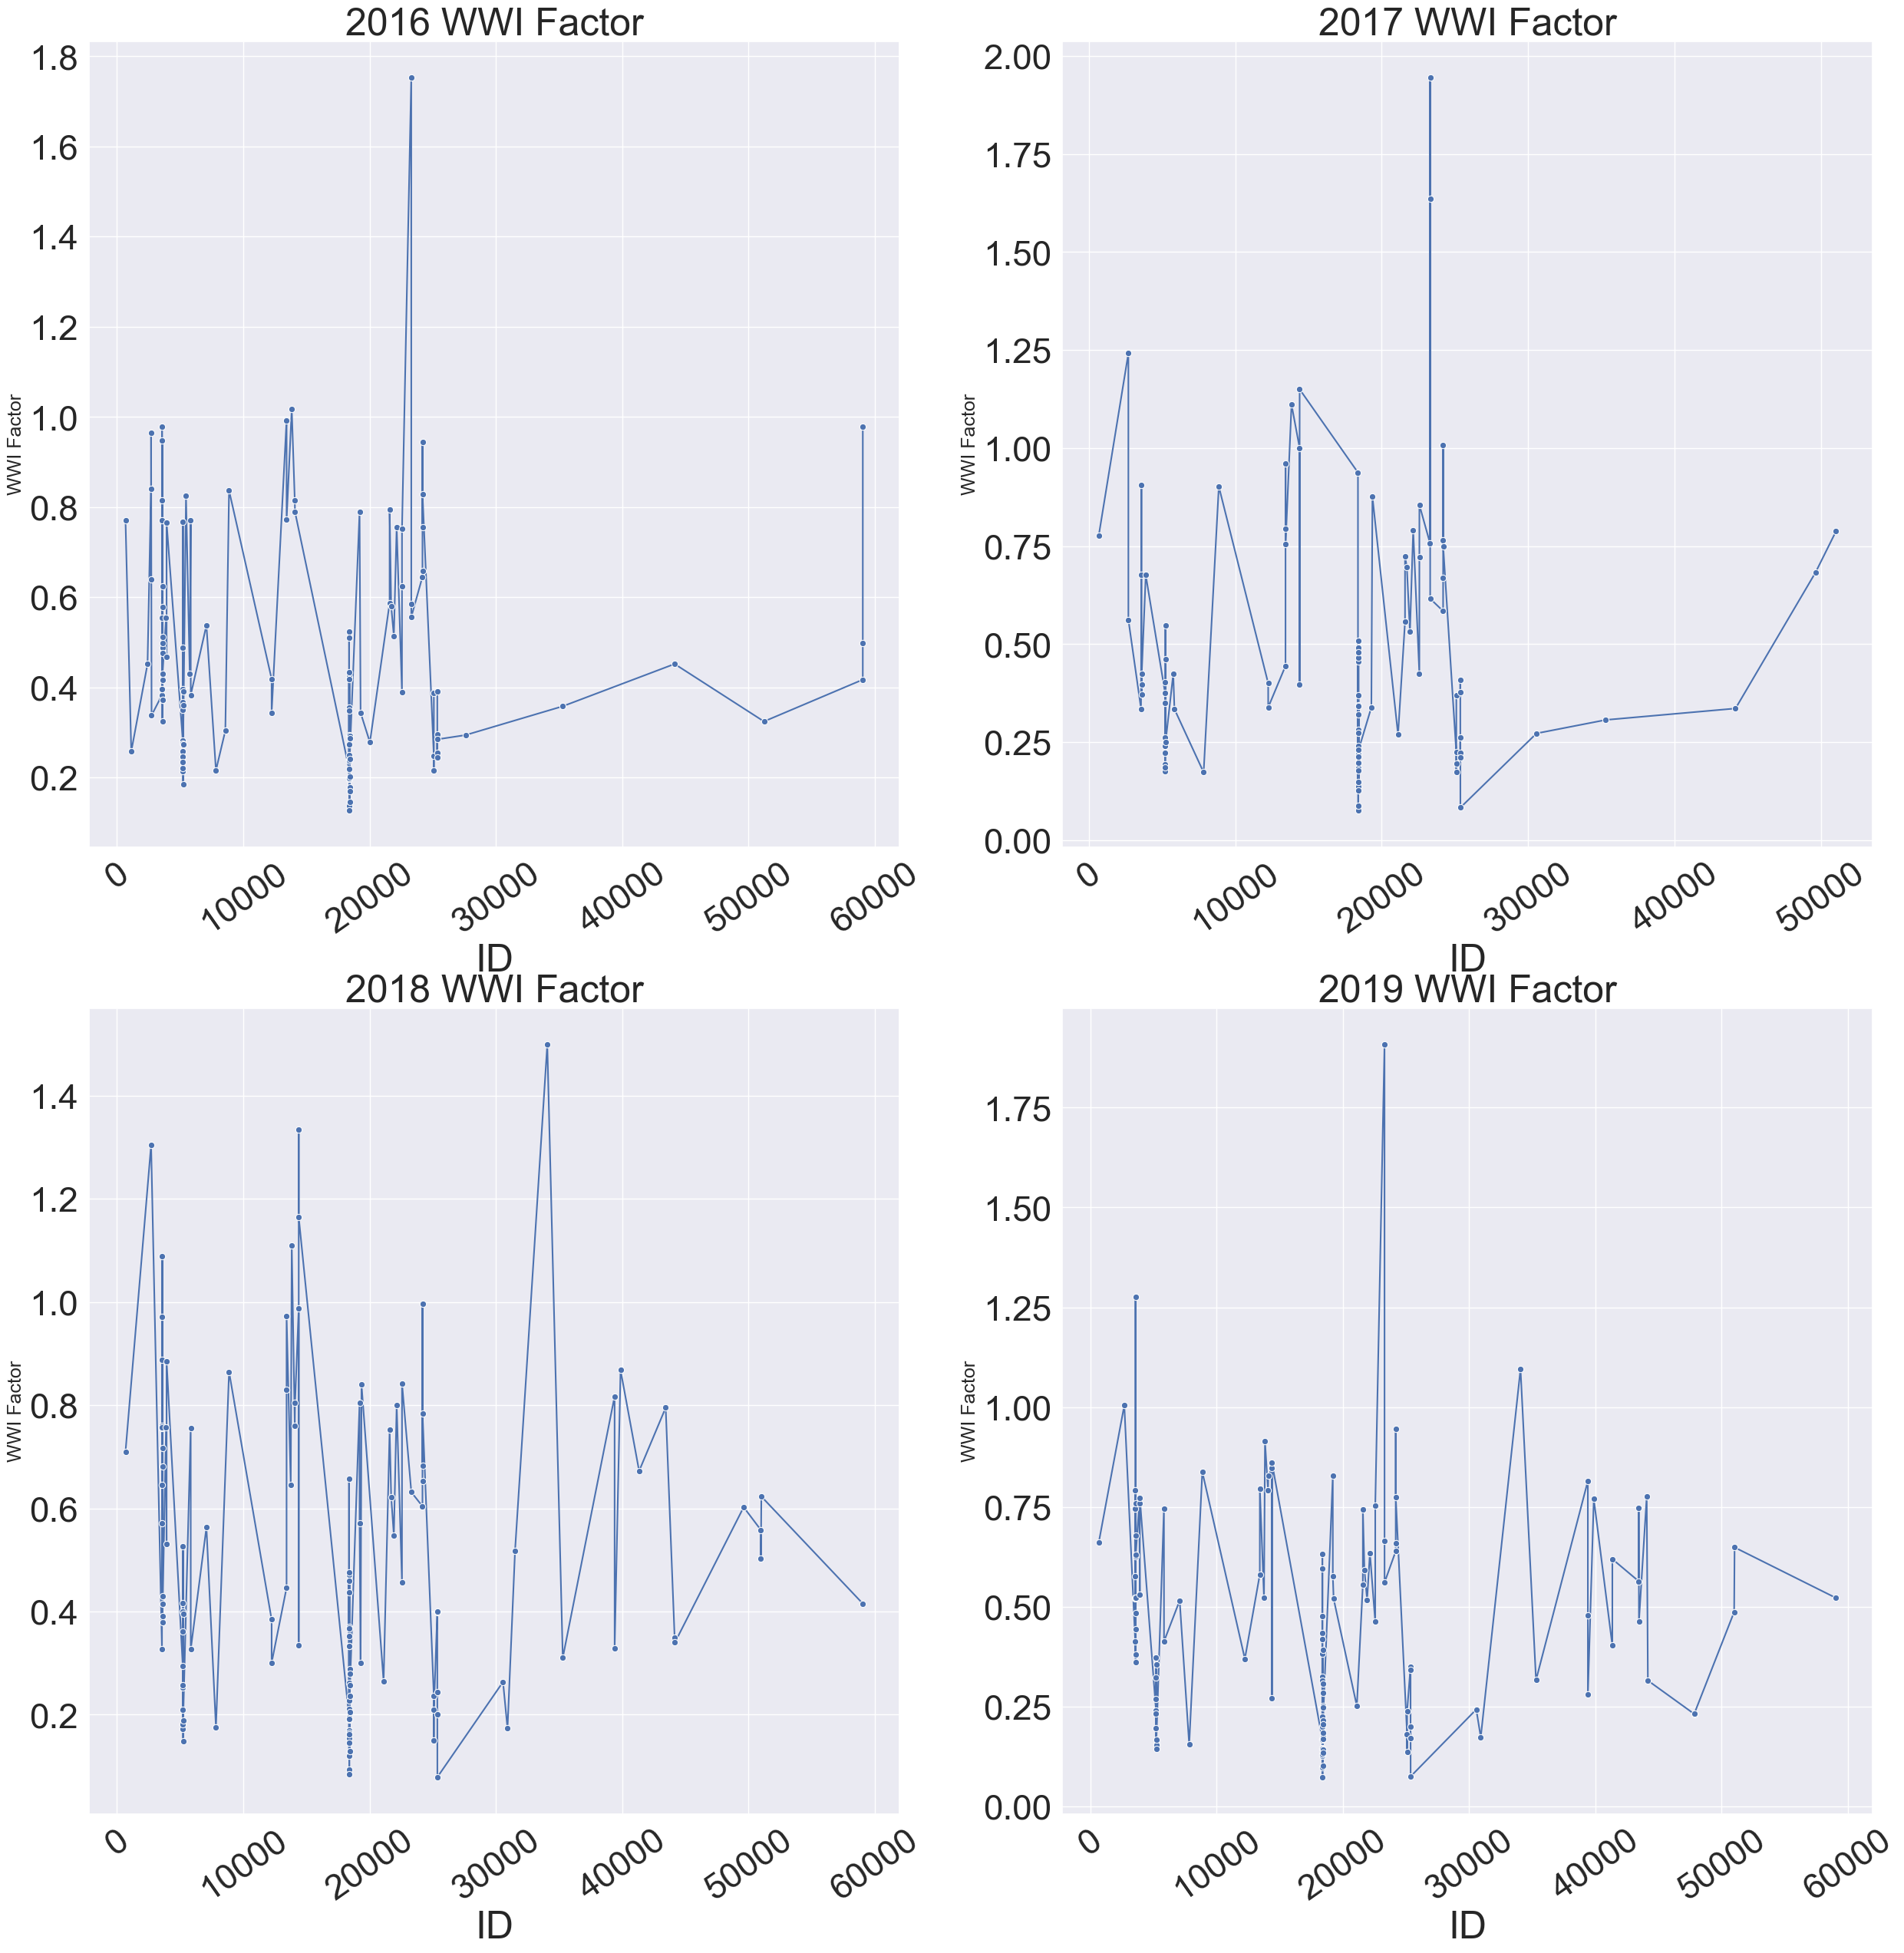

In [30]:
sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)
import seaborn as sns
ami16=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2016]
ami17=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2017]
ami18=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2018]
ami19=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2019]


fig, ax = plt.subplots(2,2)

ax1 = sns.lineplot(x=ami16['ID'],y=ami16['Average_WWI'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.lineplot(x=ami17['ID'],y=ami17['Average_WWI'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.lineplot(x=ami18['ID'],y=ami18['Average_WWI'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.lineplot(x=ami19['ID'],y=ami19['Average_WWI'],
                   markers=True, marker="o", dashes=False,sort=True,ax=ax[1,1]) 
plt.xticks(rotation = 'vertical')
#ax1.get_legend().remove()
#ax2.get_legend().remove()
#ax3.get_legend().remove()
#ax4.get_legend().remove()
ax1.title.set_text('2016 WWI Factor')
ax2.title.set_text('2017 WWI Factor')
ax3.title.set_text('2018 WWI Factor')
ax4.title.set_text('2019 WWI Factor')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=35)
ax1.set_ylabel('WWI Factor',fontsize=18)
ax1.set_xlabel('ID')
ax2.set_ylabel('WWI Factor',fontsize=18 )
ax2.set_xlabel('ID')
ax3.set_ylabel('WWI Factor',fontsize=18 )
ax3.set_xlabel('ID')
ax4.set_ylabel('WWI Factor',fontsize=18 )
ax4.set_xlabel('ID')
plt.show()

# Now Develop Seasonal Factor like average of June/July/August divided by average of December/January/March) 

In [31]:
daily_vol10=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/eco_daily_volume_2019_2016_data.csv')

In [32]:
dos=pd.merge(daily_vol10,Permanent_counter,left_on=['ID','year'],right_on=['ID','year'],how='inner')
dos.head()

Unnamed: 0_x   ID  year  month  day Day of Week  weekno  Daily_volume  \
0             0  671  2016      1    4      Monday       1         12.00   
1             1  671  2016      1    5     Tuesday       1         18.00   
2             2  671  2016      1    6   Wednesday       1         11.00   
3             3  671  2016      1    7    Thursday       1         26.00   
4             4  671  2016      1    8      Friday       1         38.00   

   sum_hr  cum_Daily_volume  ...  flag Flag  no_of_days_weekly_data_collected  \
0      24            193.00  ...     0    0                                 7   
1      24            211.00  ...     0    0                                 7   
2      24            222.00  ...     0    0                                 7   
3      24            248.00  ...     0    0                                 7   
4      24            286.00  ...     0    0                                 7   

  Unnamed: 0_y  location  latitude  longitude  AADBT  \
0          385     urban     37.79    -122.46  53.55   
1          385     urban     37.79    -122.46  53.55   
2          385     urban     37.79    -122.46  53.55   
3          385     urban     37.79    -122.46  53.55   
4          385     urban     37.79    -122.46  53.55   

   no_of_months_data_collected           type  
0                           12  eco_permanent  
1                           12  eco_permanent  
2                           12  eco_permanent  
3                           12  eco_permanent  
4                           12  eco_permanent  

[5 rows x 25 columns]

In [33]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
dos['Day of Week'] = dos['Day of Week'].astype(cat_type)

In [34]:
# get June/July/August Data
dos678=dos[(dos['month']>5) &(dos['month']<9)]
dos678=dos678[['ID','year','Daily_volume']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['ID','year'])['Daily_volume'].mean()}).reset_index()
dos678c.head()

ID  year  Average Daily Count678
0   671  2016                   59.43
1   671  2017                   60.21
2   671  2018                   52.62
3   671  2019                   56.71
4  1127  2016                   72.05

In [35]:
# get December/January/March Data
dos12=dos.loc[dos['month']==12]
dos1=dos.loc[dos['month']==1]
dos3=dos.loc[dos['month']==3]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['ID','year','Daily_volume']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['ID','year'])['Daily_volume'].mean()}).reset_index()
dos12131.head()

ID  year  Average Daily Count12131
0   671  2016                     41.40
1   671  2017                     53.36
2   671  2018                     51.47
3   671  2019                     38.39
4  1127  2016                     68.82

In [36]:
dos12131.shape,dos678c.shape

((497, 3), (497, 3))

In [38]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['ID','year'],right_on=['ID','year'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['ID','year','seasonal_factor']]
seasonal_data.head()

ID  year  seasonal_factor
0   671  2016             1.44
1   671  2017             1.13
2   671  2018             1.02
3   671  2019             1.48
4  1127  2016             1.05

In [39]:
seasonal_data['seasonal_factor'].describe()

count   497.00
mean      1.72
std       2.55
min       0.04
25%       1.28
50%       1.39
75%       1.56
max      36.36
Name: seasonal_factor, dtype: float64

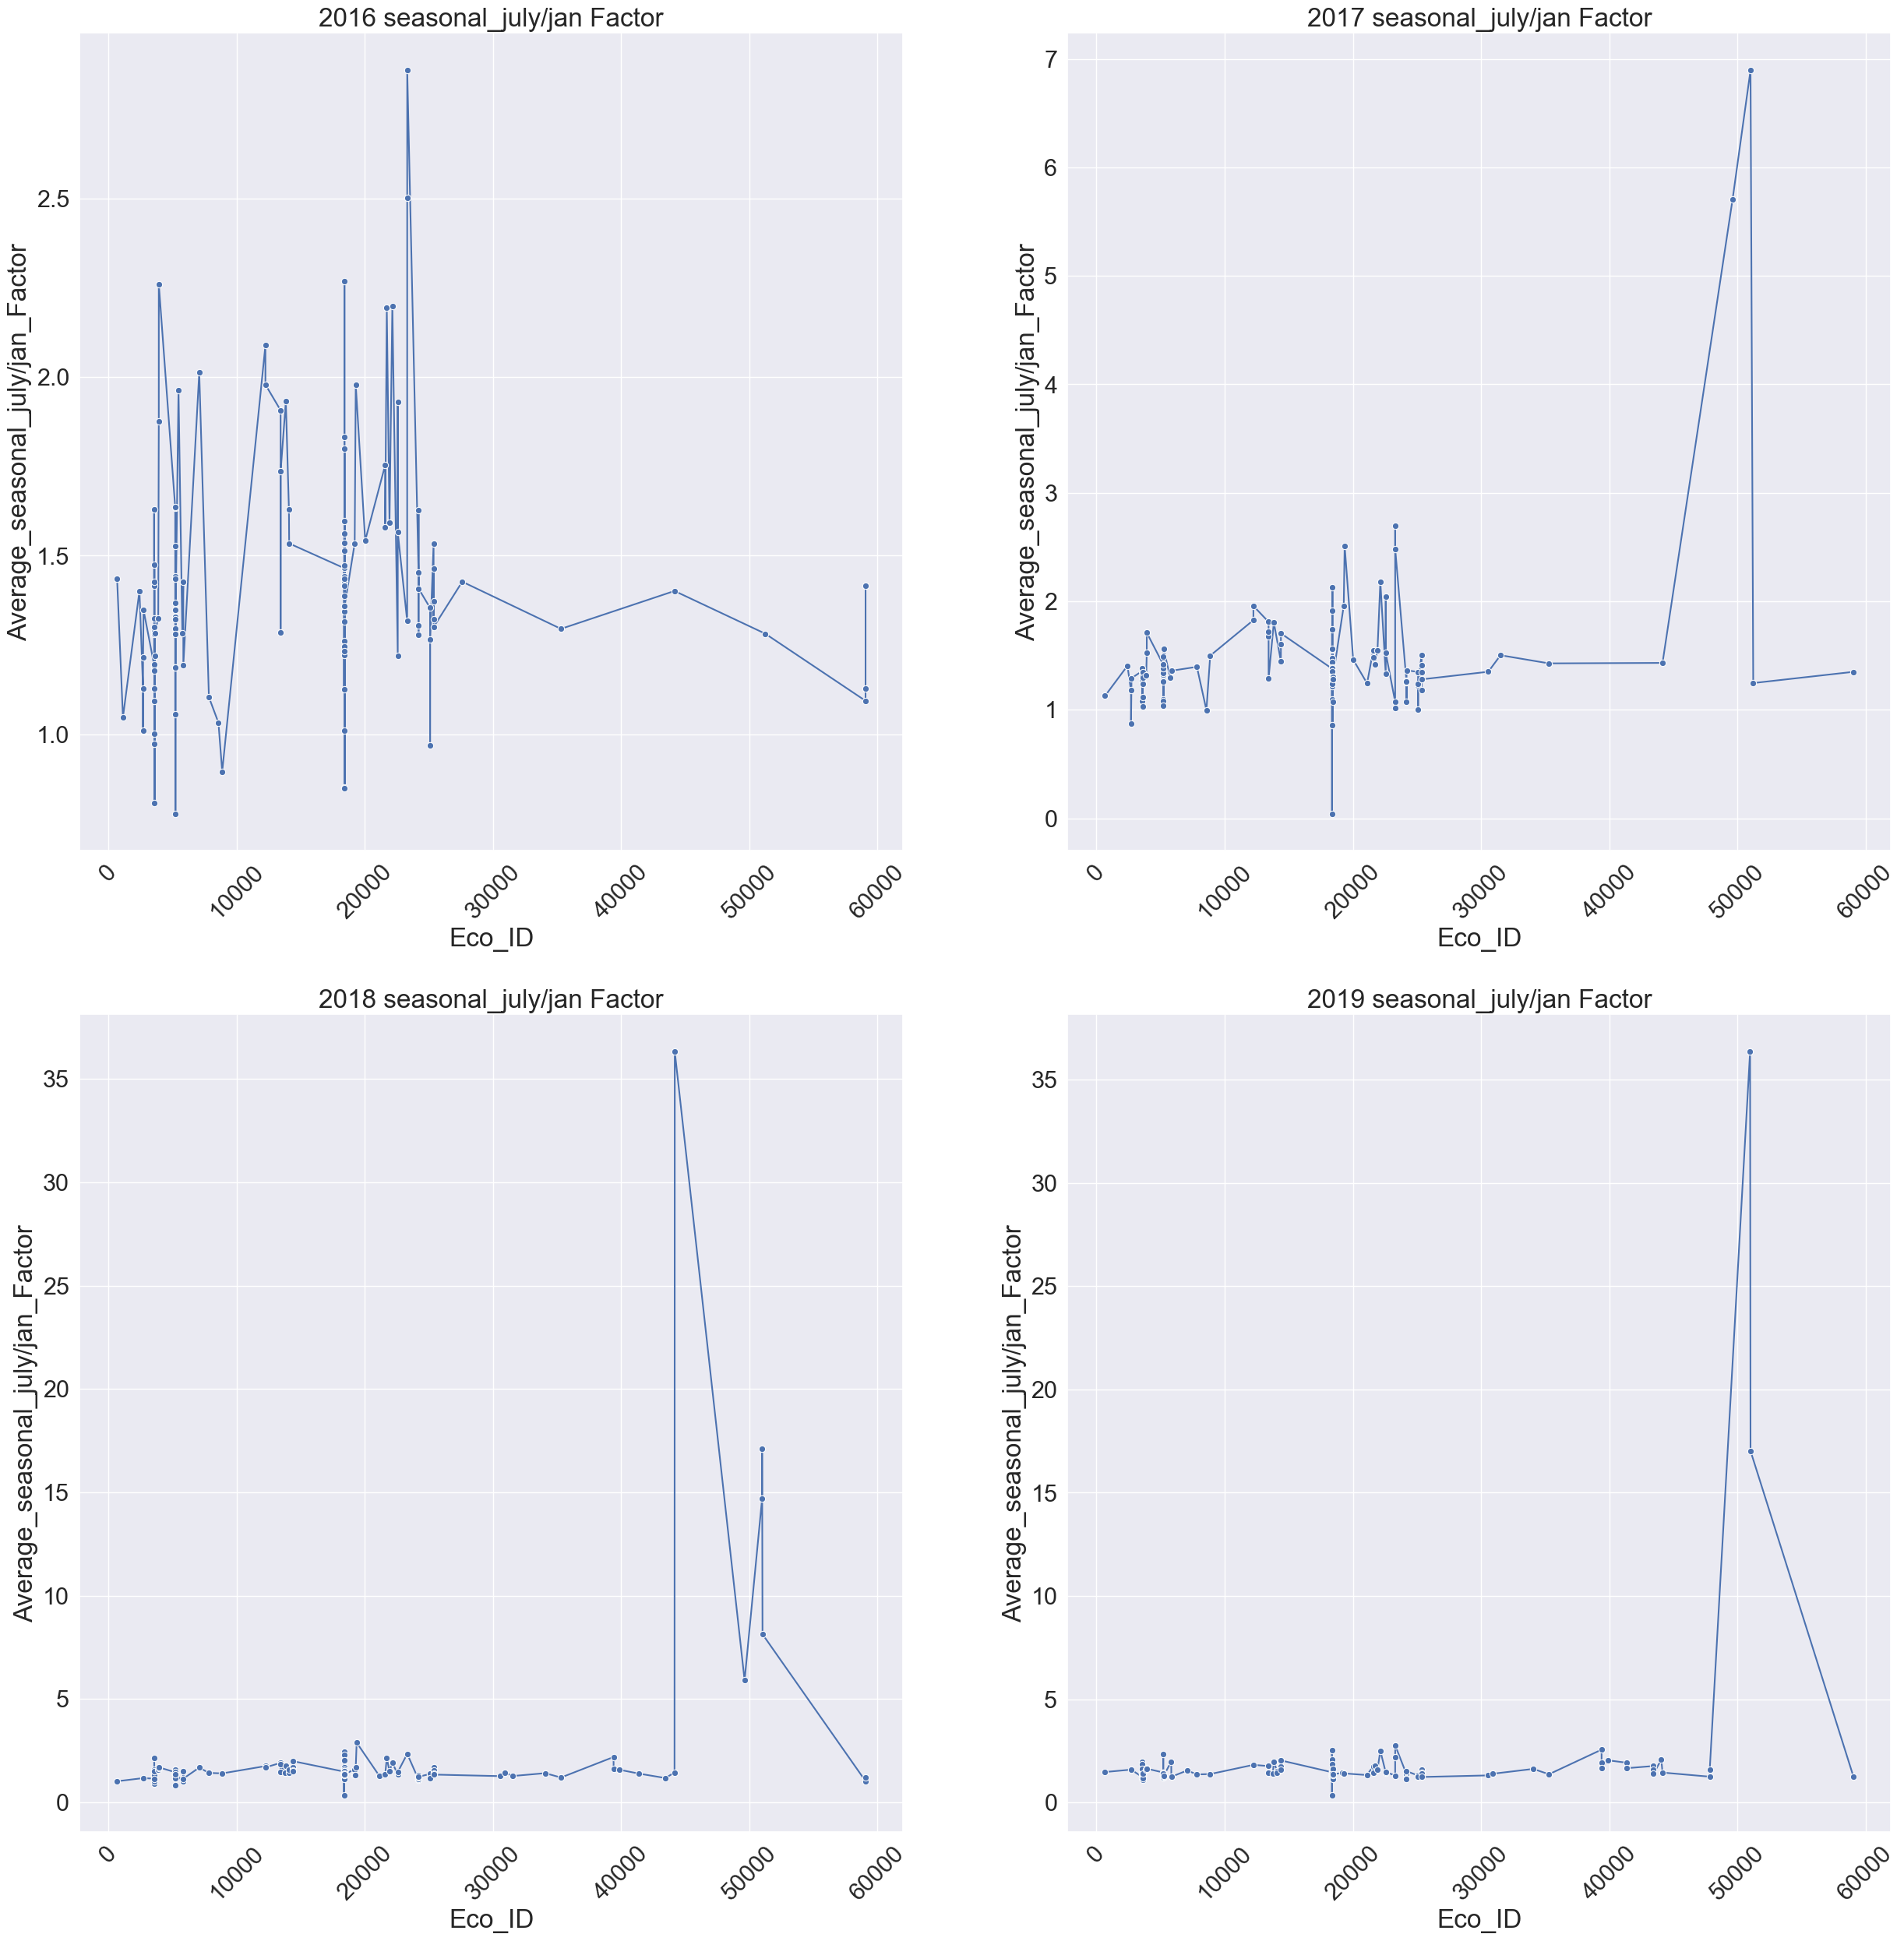

In [40]:
#july_jan=seasonal_data.loc[seasonal_data['seasonal_factor']<11]
sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=2.0)
d16=seasonal_data.loc[seasonal_data['year']==2016]
d17=seasonal_data.loc[seasonal_data['year']==2017]
d18=seasonal_data.loc[seasonal_data['year']==2018]
d19=seasonal_data.loc[seasonal_data['year']==2019]


import seaborn as sns


fig, ax = plt.subplots(2,2)

ax1 = sns.lineplot(x=d16['ID'],y=d16['seasonal_factor'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.lineplot(x=d17['ID'],y=d17['seasonal_factor'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.lineplot(x=d18['ID'],y=d18['seasonal_factor'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.lineplot(x=d19['ID'],y=d19['seasonal_factor'],
                   markers=True, marker="o", dashes=False,sort=True,ax=ax[1,1]) 
plt.xticks(rotation = 'vertical')
#ax1.get_legend().remove()
#ax2.get_legend().remove()
#ax3.get_legend().remove()
#ax4.get_legend().remove()
ax1.title.set_text('2016 seasonal_july/jan Factor')
ax2.title.set_text('2017 seasonal_july/jan Factor')
ax3.title.set_text('2018 seasonal_july/jan Factor')
ax4.title.set_text('2019 seasonal_july/jan Factor')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax1.set_ylabel('Average_seasonal_july/jan_Factor' )
ax1.set_xlabel('Eco_ID')
ax2.set_ylabel('Average_seasonal_july/jan_Factor' )
ax2.set_xlabel('Eco_ID')
ax3.set_ylabel('Average_seasonal_july/jan_Factor' )
ax3.set_xlabel('Eco_ID')
ax4.set_ylabel('Average_seasonal_july/jan_Factor' )
ax4.set_xlabel('Eco_ID')
plt.show()

In [41]:
# combine AMI_PMI_WWI and Seasonality
AAMI_PMI_WWI_WWI_Seasonal=pd.merge(AMI_PMI_WWI,seasonal_data,left_on=['ID','year'],right_on=['ID','year'],how='outer')
AAMI_PMI_WWI_WWI_Seasonal.head()

ID  year  Max_WWI  Average_WWI  Weekday_Aergage_AMI  Weekend_Aergage_AMI  \
0   671  2016     2.23         0.77                 0.70                 0.32   
1   671  2017     2.89         0.78                 0.74                 0.38   
2   671  2018     1.35         0.71                 0.86                 0.29   
3   671  2019     1.44         0.66                 0.82                 0.34   
4  1127  2016     2.22         0.26                 2.05                 0.58   

   Average AMI_wday_wend  Max_weekend_AMI  Max_weekday_AMI  Daily_Max_AMI  \
0                   2.17             0.36             0.93           0.93   
1                   1.97             0.44             1.02           1.02   
2                   2.97             0.30             1.43           1.43   
3                   2.41             0.35             1.21           1.21   
4                   3.51             0.74             2.24           2.24   

   ...  Average PMI_wday_wend  Max_weekday_PMI  Max_weekend_PMI  \
0  ...                   2.21             1.23             0.49   
1  ...                   2.07             1.21             0.49   
2  ...                   2.73             1.30             0.39   
3  ...                   2.56             1.13             0.42   
4  ...                   0.89             0.78             0.91   

   max_daily_am/pm  max_daily_am/pm_value  max_weekend_am/pm  \
0               PM                   1.23                PMI   
1               PM                   1.21                PMI   
2               AM                   1.43                PMI   
3               AM                   1.21                PMI   
4               AM                   2.24                PMI   

  max_weekend_am/pm_Value  max_weekday_am/pm max_weekday_am/pm_value  \
0                    0.49                PMI                    1.23   
1                    0.49                PMI                    1.21   
2                    0.39                AMI                    1.43   
3                    0.42                AMI                    1.21   
4                    0.91                AMI                    2.24   

   seasonal_factor  
0             1.44  
1             1.13  
2             1.02  
3             1.48  
4             1.05  

[5 rows x 23 columns]

In [42]:
AAMI_PMI_WWI_WWI_Seasonal.shape

(497, 23)

In [43]:
# add lat and long with location
# bring the lat and long of the counters
loc=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/Eco_combined_data_rural_vs_urban_before_QA_QC.csv')
loc1=loc[['ID','year','latitude','longitude','location']]
loc2=loc1.drop_duplicates(subset=['ID','latitude','longitude'], keep='first')
loc2.shape

(406, 5)

In [44]:
# bring the location based on lat and long
def city_state_country(row):
    coord = f"{row['latitude']}, {row['longitude']}"
    sleep(1)
    location = geolocator.reverse(coord, exactly_one=True, language='en')
    if not location:
        # if you see many in a row, it's probably Nominatim blocking you.
        # if it's just every once in a while, there were just some bad results. 
        print('Failed with coord: ', coord)
        row['road'],row['city'],row['county'], row['state'], row['country'] = None, None, None
        return row
    address = location.raw['address']
    city = address.get('city', '')
    county=address.get('county', '')
    state = address.get('state', '')
    country = address.get('country', '')
    row['road']=address.get('road', '')
    row['city'] = city
    row['county'] = county
    row['state'] = state
    row['country'] = country
    return row

In [45]:
city_state1 = loc2.apply(city_state_country, axis=1)
city_state1.head()

ID  year  latitude  longitude location                    road  \
0        671  2016     37.79    -122.46    urban    Bay Area Ridge Trail   
35064   1127  2016     37.80    -122.42    urban                Broadway   
70128   2415  2016     37.77    -122.44    urban             Fell Street   
105192  2691  2016     35.29    -120.66    urban  Rail Road Safety Trail   
140256  2692  2016     35.29    -120.66    urban  Rail Road Safety Trail   

                   city                  county       state        country  
0         San Francisco                          California  United States  
35064     San Francisco                          California  United States  
70128     San Francisco                          California  United States  
105192  San Luis Obispo  San Luis Obispo County  California  United States  
140256  San Luis Obispo  San Luis Obispo County  California  United States

In [46]:
city_state1=city_state1.drop(['year'],axis=1)

In [51]:
AAMI_PMI_WWI_WWI_Seasonal1=pd.merge(AAMI_PMI_WWI_WWI_Seasonal,city_state1, left_on=['ID'], right_on=['ID'], how='inner')
AAMI_PMI_WWI_WWI_Seasonal1.head()

ID  year  Max_WWI  Average_WWI  Weekday_Aergage_AMI  Weekend_Aergage_AMI  \
0   671  2016     2.23         0.77                 0.70                 0.32   
1   671  2017     2.89         0.78                 0.74                 0.38   
2   671  2018     1.35         0.71                 0.86                 0.29   
3   671  2019     1.44         0.66                 0.82                 0.34   
4  1127  2016     2.22         0.26                 2.05                 0.58   

   Average AMI_wday_wend  Max_weekend_AMI  Max_weekday_AMI  Daily_Max_AMI  \
0                   2.17             0.36             0.93           0.93   
1                   1.97             0.44             1.02           1.02   
2                   2.97             0.30             1.43           1.43   
3                   2.41             0.35             1.21           1.21   
4                   3.51             0.74             2.24           2.24   

   ...  max_weekday_am/pm_value  seasonal_factor  latitude  longitude  \
0  ...                     1.23             1.44     37.79    -122.46   
1  ...                     1.21             1.13     37.79    -122.46   
2  ...                     1.43             1.02     37.79    -122.46   
3  ...                     1.21             1.48     37.79    -122.46   
4  ...                     2.24             1.05     37.80    -122.42   

   location                  road           city  county       state  \
0     urban  Bay Area Ridge Trail  San Francisco          California   
1     urban  Bay Area Ridge Trail  San Francisco          California   
2     urban  Bay Area Ridge Trail  San Francisco          California   
3     urban  Bay Area Ridge Trail  San Francisco          California   
4     urban              Broadway  San Francisco          California   

         country  
0  United States  
1  United States  
2  United States  
3  United States  
4  United States  

[5 rows x 31 columns]

In [48]:
AAMI_PMI_WWI_WWI_Seasonal1.shape

(497, 31)

In [49]:
check=AAMI_PMI_WWI_WWI_Seasonal1.loc[AAMI_PMI_WWI_WWI_Seasonal1['county']=='El Dorado County']
check.groupby(['year','county'])['ID'].count()

year  county          
2017  El Dorado County    2
2018  El Dorado County    4
2019  El Dorado County    2
Name: ID, dtype: int64

# Add Strava Volume

In [50]:
Strava=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/eco_stv_all.csv')
Strava.head()

Unnamed: 0     ID  year  latitude  longitude      edgeUID        osmId  \
0           0    671  2018     37.79    -122.46 308723101.00 215845474.00   
1           1   1127  2018     37.80    -122.42 308779961.00  87297166.00   
2           2  44181  2018     37.80    -122.42 308779961.00  87297166.00   
3           3   2415  2018     37.77    -122.44 308725144.00 907910631.00   
4           4  44161  2018     37.77    -122.44 308725144.00 907910631.00   

  dist  stv_total  stv_com_total  stv_rec_total  stv_com_ratio  stv_rec_ratio  
0   d4    4890.00         260.00        4630.00           0.05           0.95  
1   d4     405.00         150.00         255.00           0.37           0.63  
2   d4     405.00         150.00         255.00           0.37           0.63  
3   d4   30655.00       11705.00       18950.00           0.38           0.62  
4   d4   30655.00       11705.00       18950.00           0.38           0.62

In [60]:
indices_strava=pd.merge(AAMI_PMI_WWI_WWI_Seasonal1,Strava,left_on=['ID','year','latitude','longitude'],right_on=['ID','year','latitude','longitude'],how='inner')
indices_strava.head()

ID  year  Max_WWI  Average_WWI  Weekday_Aergage_AMI  Weekend_Aergage_AMI  \
0   671  2016     2.23         0.77                 0.70                 0.32   
1   671  2017     2.89         0.78                 0.74                 0.38   
2   671  2018     1.35         0.71                 0.86                 0.29   
3   671  2019     1.44         0.66                 0.82                 0.34   
4  1127  2016     2.22         0.26                 2.05                 0.58   

   Average AMI_wday_wend  Max_weekend_AMI  Max_weekday_AMI  Daily_Max_AMI  \
0                   2.17             0.36             0.93           0.93   
1                   1.97             0.44             1.02           1.02   
2                   2.97             0.30             1.43           1.43   
3                   2.41             0.35             1.21           1.21   
4                   3.51             0.74             2.24           2.24   

   ...        country  Unnamed: 0      edgeUID        osmId  dist  stv_total  \
0  ...  United States           0 308723101.00 215845474.00    d4        NaN   
1  ...  United States           0 308723101.00 215845474.00    d4        NaN   
2  ...  United States           0 308723101.00 215845474.00    d4    4890.00   
3  ...  United States           0 308723101.00 215845474.00    d4    4625.00   
4  ...  United States           1 308779961.00  87297166.00    d4        NaN   

  stv_com_total  stv_rec_total stv_com_ratio  stv_rec_ratio  
0           NaN            NaN           NaN            NaN  
1           NaN            NaN           NaN            NaN  
2        260.00        4630.00          0.05           0.95  
3        255.00        4370.00          0.06           0.94  
4           NaN            NaN           NaN            NaN  

[5 rows x 40 columns]

In [61]:
indices_strava.shape

(416, 40)

In [62]:
indices_strava.groupby(['year'])['ID'].count()

year
2016    108
2017    102
2018    107
2019     99
Name: ID, dtype: int64

In [63]:
# save all indices
indices_strava.to_csv('D:/Bike_ped Exposure Model Project/Processed Data/Updated_indices.csv')

# Calculate AMI and PMI Index for Short Term sites

In [70]:
sc_data_all_4=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2016_2019.csv')

In [71]:
# separate the data that supporting data to assign travel pattern
sc_data_all11=sc_data_all_4[(sc_data_all_4['starttime']=="07:00:00") & (sc_data_all_4['endtime']=="08:00:00")]
sc_data_all12=sc_data_all_4[(sc_data_all_4['starttime']=="08:00:00") & (sc_data_all_4['endtime']=="09:00:00")]
sc_data_all1=pd.concat([sc_data_all11,sc_data_all12],axis=0)
sc_data_all1amg=pd.DataFrame({'AM_count' : sc_data_all1.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

sc_data_all22=sc_data_all_4[(sc_data_all_4['starttime']=="11:00:00") & (sc_data_all_4['endtime']=="12:00:00")]
sc_data_all23=sc_data_all_4[(sc_data_all_4['starttime']=="12:00:00") & (sc_data_all_4['endtime']=="13:00:00")]
sc_data_all2=pd.concat([sc_data_all22,sc_data_all23],axis=0)
sc_data_all2pmg=pd.DataFrame({'AMPM_count' : sc_data_all2.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

sc_data_all33=sc_data_all_4[(sc_data_all_4['starttime']=="17:00:00") & (sc_data_all_4['endtime']=="18:00:00")]
sc_data_all34=sc_data_all_4[(sc_data_all_4['starttime']=="18:00:00") & (sc_data_all_4['endtime']=="19:00:00")]
sc_data_all3=pd.concat([sc_data_all33,sc_data_all34],axis=0)
sc_data_all3amg=pd.DataFrame({'PM_count' : sc_data_all3.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
sc_data_all_am_ampm=pd.merge(sc_data_all1amg,sc_data_all2pmg,left_on=["ID",'Leg','year'],right_on=["ID",'Leg','year'],how='inner')
# Calculate the AMI
sc_data_all_am_ampm['AMI']=sc_data_all_am_ampm['AM_count']/sc_data_all_am_ampm['AMPM_count']
sc_data_all_am_ampm.head()

ID Leg    year  AM_count  AMPM_count  AMI
0  CH11   E 2019.00         4           2 2.00
1  CH11   W 2019.00         4           1 4.00
2  CH13   E 2019.00         7           1 7.00
3  CH13   W 2019.00         7           1 7.00
4  CH15   E 2019.00         7           5 1.40

In [72]:
sc_data_all_am_ampm.groupby(['Leg','year'])['ID'].count()

Leg  year   
E    2016.00    139
     2017.00     26
     2018.00     68
     2019.00     85
N    2016.00    146
     2017.00     58
     2018.00     61
     2019.00     77
S    2016.00    142
     2017.00     45
     2018.00     60
     2019.00     73
W    2016.00    116
     2017.00     30
     2018.00     41
     2019.00     76
Name: ID, dtype: int64

In [73]:
sc_data_all_4.groupby(['Leg','year'])['ID'].count()

Leg  year   
E    2016.00    2685
     2017.00    1158
     2018.00    2031
     2019.00    1334
N    2016.00    2721
     2017.00    1442
     2018.00    1822
     2019.00    1147
NE   2018.00       3
NW   2018.00       4
S    2016.00    2610
     2017.00    1588
     2018.00    1886
     2019.00    1317
W    2016.00    2421
     2017.00    1052
     2018.00    1501
     2019.00    1189
Name: ID, dtype: int64

In [74]:
# Join ampm and Pm count by eco id
sc_data_all_pm_ampm=pd.merge(sc_data_all3amg,sc_data_all2pmg,left_on=["ID",'Leg','year'],right_on=["ID",'Leg','year'],how='inner')
# Calculate the PMI
sc_data_all_pm_ampm['PMI']=sc_data_all_pm_ampm['PM_count']/sc_data_all_pm_ampm['AMPM_count']
sc_data_all_pm_ampm.head()

ID Leg    year  PM_count  AMPM_count  PMI
0   AC20160   E 2016.00         7           2 3.50
1   AC20160   N 2016.00         4           4 1.00
2   AC20160   S 2016.00         8           3 2.67
3   AC20160   W 2016.00        13           5 2.60
4  AC201610   E 2016.00        22           7 3.14

In [75]:
sc_data_all_pm_ampm.groupby(['Leg','year'])['ID'].count()

Leg  year   
E    2016.00    76
     2017.00    41
     2018.00    88
     2019.00    89
N    2016.00    80
     2017.00    66
     2018.00    80
     2019.00    73
NW   2018.00     1
S    2016.00    75
     2017.00    49
     2018.00    82
     2019.00    69
W    2016.00    67
     2017.00    39
     2018.00    66
     2019.00    85
Name: ID, dtype: int64

In [76]:
sh_ami_pmi=pd.merge(sc_data_all_am_ampm,sc_data_all_pm_ampm,left_on=['ID','Leg','year'],right_on=['ID','Leg','year'], how='outer')
sh_ami_pmi['am_pm_ratio']=sh_ami_pmi['AMI']/sh_ami_pmi['PMI']
sh_ami_pmi.head()

ID Leg    year  AM_count  AMPM_count_x  AMI  PM_count  AMPM_count_y  PMI  \
0  CH11   E 2019.00      4.00          2.00 2.00      4.00          2.00 2.00   
1  CH11   W 2019.00      4.00          1.00 4.00      2.00          1.00 2.00   
2  CH13   E 2019.00      7.00          1.00 7.00      1.00          1.00 1.00   
3  CH13   W 2019.00      7.00          1.00 7.00      1.00          1.00 1.00   
4  CH15   E 2019.00      7.00          5.00 1.40      2.00          5.00 0.40   

   am_pm_ratio  
0         1.00  
1         2.00  
2         7.00  
3         7.00  
4         3.50

In [77]:
# Count both and AMI and PMI Presence
am_pm_check=sh_ami_pmi.loc[sh_ami_pmi['am_pm_ratio']>=0]

In [78]:
# count that have both AMI and PMI
am_pm_check.groupby(['Leg','year'])['ID'].count()

Leg  year   
E    2016.00    56
     2017.00    24
     2018.00    59
     2019.00    81
N    2016.00    50
     2017.00    55
     2018.00    54
     2019.00    66
S    2016.00    48
     2017.00    40
     2018.00    54
     2019.00    62
W    2016.00    45
     2017.00    24
     2018.00    37
     2019.00    72
Name: ID, dtype: int64

# Calculate the WWI Index for the short term sites

In [79]:
# Calculate weekend Count by eco id
sc_data_all_weekend=sc_data_all_4.loc[sc_data_all_4['weekday_Status']==1]
sc_data_all_weekendg=pd.DataFrame({'Weekend_count' : sc_data_all_weekend.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

# Calculate weekday count by Eco ID
sc_data_all_weeekday=sc_data_all_4.loc[sc_data_all_4['weekday_Status']==0]
sc_data_all_weekdayg=pd.DataFrame({'Weekday_count' : sc_data_all_weeekday.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

# Join weekend and weekday count by eco id
sc_data_all_weekend_weekday=pd.merge(sc_data_all_weekendg,sc_data_all_weekdayg,left_on=["ID",'Leg','year'],right_on=["ID",'Leg','year'],how='inner')
# Calculate the WWI
sc_data_all_weekend_weekday['WWI']=sc_data_all_weekend_weekday['Weekend_count']/sc_data_all_weekend_weekday['Weekday_count']
sc_data_all_weekend_weekday

ID Leg    year  Weekend_count  Weekday_count  WWI
0   Los_Gatos0   E 2016.00             39             22 1.77
1   Los_Gatos0   N 2016.00             65             26 2.50
2   Los_Gatos0   S 2016.00             89             22 4.05
3   Los_Gatos0   W 2016.00              0              0  NaN
4   Los_Gatos1   E 2016.00             73             50 1.46
5   Los_Gatos1   N 2016.00             49             21 2.33
6   Los_Gatos1   S 2016.00              8              8 1.00
7   Los_Gatos1   W 2016.00             26             14 1.86
8   Los_Gatos2   E 2016.00             17             69 0.25
9   Los_Gatos2   N 2016.00             16             68 0.24
10  Los_Gatos2   S 2016.00              0              0  NaN
11  Los_Gatos2   W 2016.00              7             38 0.18
12  Los_Gatos3   E 2016.00             66             25 2.64
13  Los_Gatos3   N 2016.00              0              0  NaN
14  Los_Gatos3   S 2016.00             15             13 1.15
15  Los_Gatos3   W 2016.00             37             27 1.37
16  Los_Gatos4   E 2016.00              1              0  inf
17  Los_Gatos4   N 2016.00             20             19 1.05
18  Los_Gatos4   S 2016.00             25             35 0.71
19  Los_Gatos4   W 2016.00             28             35 0.80
20  Los_Gatos5   E 2016.00             49             76 0.64
21  Los_Gatos5   N 2016.00             19             12 1.58
22  Los_Gatos5   S 2016.00             14             30 0.47
23  Los_Gatos5   W 2016.00             40             48 0.83
24  Los_Gatos6   E 2016.00             25             49 0.51
25  Los_Gatos6   N 2016.00             51             45 1.13
26  Los_Gatos6   S 2016.00             41             36 1.14
27  Los_Gatos6   W 2016.00              2             67 0.03
28  Los_Gatos7   E 2016.00             27             28 0.96
29  Los_Gatos7   N 2016.00            172            108 1.59
30  Los_Gatos7   S 2016.00              0              0  NaN
31  Los_Gatos7   W 2016.00            144            108 1.33
32  Los_Gatos8   E 2016.00              4             52 0.08
33  Los_Gatos8   N 2016.00              1             14 0.07
34  Los_Gatos8   S 2016.00              1              3 0.33
35  Los_Gatos8   W 2016.00             11             65 0.17

In [ ]:
# end of the Code